#Multilayer Perceptrons (MLPs) and Activation Functions

# A. Bài toán 1: Dự đoán hiệu suất xe hơi
Task về regression cho một tập data Auto_MPG_data.csv dựa vào 9 features của xe ô tô để dự đoán năng lượng tiêu thụ (MPG)

## 1.Tải bộ dữ liệu
Bước đầu tiên là tải dữ liệu cho bài bằng lệnh "!gdown":

In [2]:
%cd G:\AIO\EXERCISE\AIO-2024\MODULE05\WEEK03\data

G:\AIO\EXERCISE\AIO-2024\MODULE05\WEEK03\data


In [ ]:
#https://drive.google.com/file/d/1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu/view?usp=drive_link

!gdown 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

Downloading...
From: https://drive.google.com/uc?id=1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu
To: /content/drive/MyDrive/Colab Notebooks/MODULE05/data/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 37.6MB/s]


In [3]:
%cd ..

G:\AIO\EXERCISE\AIO-2024\MODULE05\WEEK03


## 2.Import các thư viện cần thiết
Trong bài tập này, chúng ta cần import thư viện PyTorch để cài đặt mô hình

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 3.Cài đặt giá trị ngẫu nhiên cố định
Để kết quả trả về là cố định với mỗi lần chúng ta thực hiện chạy lại từ đầu file notebook, thama số ngẫu nhiên (seed) cần phải được cài đặt với tất cả các thư viện và hàm có liên quan đến phép ngẫu nhiên. Trong bài này, các thư viện NumPy, PyTorch, scikit-learn sẽ có một vài hàm có sử dụng tính ngẫu nhiên, vì vậy ta sẽ cài đặt chung một giá trị ngẫu nhiên như sau

In [37]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
  torch.cuda.manual_seed(random_state)

## 4.Cài đặt thiết bị tính toán
Đối với PyTorch, để tận dụng sức mạnh của GPU nếu có sẵn (trong colab các bạn cần điều chỉnh runtime sang GPU để có thể kích hoạt được GPU), ta cần chỉ định thiết bị mà mô hình sẽ được chạy. Đoạn code dưới đây sẽ tự động chọn GPU (nếu khả dụng), hoặc quay về CPU khi GPU không được hỗ trợ

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 5.Đọc bộ dữ liệu
Bộ dữ liệu trong bài được lưu dưới dạng file .csv, vì vậy chúng ta sẽ sử dụng thư viện pandas để đọc data này lên

In [39]:
dataset_path = 'data/Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)

In [40]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [41]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Europe        392 non-null    int64  
 8   Japan         392 non-null    int64  
 9   USA           392 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 30.8 KB


In [42]:
dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,0.173469,0.201531,0.625000
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.379136,0.401656,0.484742
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,0.000000,0.000000,0.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,0.000000,0.000000,1.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [43]:
dataset.isnull().sum()

,0
MPG,0
Cylinders,0
Displacement,0
Horsepower,0
Weight,0
Acceleration,0
Model Year,0
Europe,0
Japan,0
USA,0


In [44]:
dataset.shape

(392, 10)

## 6.Tiền xử lý bộ dữ liệu
Với DataFrame vừa đọc lên, ta sẽ thực hiện một số bước tiền xử lý dữ liệu để có thể sử dụng chúng trong việc huấn luyện mô hình

### (a) Tách đặc trưng X và nhãn y

In [45]:
X = dataset.drop(columns='MPG').values
y = dataset['MPG'].values

In [46]:
X.shape,y.shape

((392, 9), (392,))

### (b) Chia bộ dữ liệu train/val/test
Với toàn bộ dữ liệu hiện tại, ta sẽ tách thành 3 bộ dữ liệu riêng biệt cho việc huấn luyện và đánh giá mô hình.
Trong bài này, ta sẽ chia ba bộ train/val/test theo tỉ lệ 7:2:1

In [47]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=val_size, random_state = random_state, shuffle=is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)

In [48]:
X_train.shape, X_val.shape, X_test.shape

((273, 9), (79, 9), (40, 9))

In [49]:
y_train.shape, y_val.shape, y_test.shape

((273,), (79,), (40,))

### (c) Chuẩn hóa đặc trưng đầu vào

In [50]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [51]:
X_train.shape, X_val.shape, X_test.shape

(torch.Size([273, 9]), torch.Size([79, 9]), torch.Size([40, 9]))

In [52]:
y_train.shape, y_val.shape, y_test.shape

(torch.Size([273]), torch.Size([79]), torch.Size([40]))

In [53]:
X_train

tensor([[-0.8414, -1.0379, -1.0381,  ..., -0.4443,  1.9045, -1.2748],
        [ 0.3676,  0.3682,  0.2230,  ..., -0.4443, -0.5251,  0.7845],
        [-0.8414, -0.9165, -0.8980,  ..., -0.4443, -0.5251,  0.7845],
        ...,
        [ 1.5766,  1.3091,  1.3439,  ..., -0.4443, -0.5251,  0.7845],
        [ 0.3676,  0.4391, -0.3375,  ..., -0.4443, -0.5251,  0.7845],
        [ 0.3676,  0.6211, -0.0573,  ..., -0.4443, -0.5251,  0.7845]])

## 7.Xây dựng DataLoader
Để có thể duyệt qua bộ dữ liệu một cách hiệu quả cho việc huấn luyện cũng như đánh giá mô hình trong PyTorch, chúng ta cần xây dựng PyTorch DataLoader. Để xây dựng DataLoader, chúng ta cần phải xây dựng PyTorch Dataset nhằm lưu dữ liệu đầu vào đầu ra trong bài toán. Theo đó, ta sẽ xây dựng một PyTorch Dataset đơn giản như sau

In [54]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

Sau khi khai báo class PyTorch Dataset, ta chỉ việc gói triển khai của các dataset này vào DataLoader là hoàn tất. Lưu ý rằng, ở đây ta sẽ khai báo luôn tham số batch size, vì DataLoader sẽ hỗ trợ chúng ta lấy batch một cách tối ưu hơn

In [55]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## 8.Xây dựng mạng MLP
Ta triển khai một mạng MLP gồm 2 lớp ẩn, theo sau mỗi lớp ẩn là hàm kích hoạt ReLU

In [56]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super().__init__()
    self.linear1 = nn.Linear(input_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)

  def forward(self, x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    x = F.relu(x)
    out = self.output(x)
    return out.squeeze(1)


Sau khi đã có cài đặt class cho kiến trúc MLP, ta sẽ khai báo biến mô hình bằng cách khai báo một đối tượng của class trên đi kèm với các tham số phù hợp với bài toán đang giải

In [57]:
'''
Theo đó, chúng ta cần điều chỉnh các tham số về số lượng node dữ liệu đầu vào
(input_dims), số node trong lớp ẩn (hidden_dims) và số node đầu ra (output_dims).
Trong bài này, input_dims chính là số lượng đặc trưng của biến X, output_dims bằng
1 vì bài toán ta làm là bài regression nên chỉ có một giá trị dự đoán. Số node trong
hidden_dims ta có thể tùy chỉnh, ở đây lấy ví dụ cài đặt = 64
'''

input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

## 9.Khai báo hàm loss và optimizer
Đối với PyTorch, ta có thể dễ dàng cài đặt hàm loss cũng như thuật toán tối ưu bằng class có sẵn. Trong bài này, ta sử dụng hàm Mean Squared Error Loss (MSELoss) cũng như thuật toán tối ưu Stochastic Gradient Descent (SGD)

In [58]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## 10.Xây dựng hàm tính điểm R2
Trong bài này, ta sẽ sử dụng thêm một độ đo khác cho bài regression là điểm R2 (Coefficient of determination)

In [59]:
def r_squared(y_true, y_pred):
  y_true = torch.Tensor(y_true).to(device)
  y_pred = torch.Tensor(y_pred).to(device)
  mean_true = torch.mean(y_true)
  ss_tot = torch.sum((y_true-mean_true)**2)
  ss_res = torch.sum((y_true-y_pred)**2)
  r2 = 1 - (ss_res/ss_tot)
  return r2

## 11.Huấn luyện mô hình
Khi đã đầy đủ tất cả gồm mô hình, dataloader, hàm loss và optimizer, chúng ta đã có thể tiến hành huấn luyện mô hình trong PyTorch

In [60]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):

  train_target = []
  val_target = []
  train_predict = []
  val_predict = []

  train_loss = 0.0
  model.train()
  for X_samples, y_samples in train_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)
    optimizer.zero_grad()
    outputs = model(X_samples)
    train_predict += outputs.tolist()
    train_target += y_samples.tolist()
    loss = criterion(outputs, y_samples)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_r2.append(r_squared(train_target, train_predict))

  val_loss = 0.0
  model.eval()
  with torch.no_grad():
    for X_samples, y_samples in val_loader:
      X_samples = X_samples.to(device)
      y_samples = y_samples.to(device)
      outputs = model(X_samples)
      val_predict += outputs.tolist()
      val_target += y_samples.tolist()
      loss = criterion(outputs, y_samples)
      val_loss += loss.item()

  val_loss /= len(val_loader)
  val_losses.append(val_loss)
  val_r2.append(r_squared(val_target, val_predict))
  print(f'\nEPOCH{epoch+1}:\tTraining loss: {train_loss:.3f}\tValidation loss: { val_loss :.3f}')


EPOCH1:	Training loss: 282.769	Validation loss: 88.672

EPOCH2:	Training loss: 137.669	Validation loss: 72.346

EPOCH3:	Training loss: 71.007	Validation loss: 19.143

EPOCH4:	Training loss: 25.083	Validation loss: 196.176

EPOCH5:	Training loss: 96.139	Validation loss: 20.444

EPOCH6:	Training loss: 17.765	Validation loss: 9.444

EPOCH7:	Training loss: 18.486	Validation loss: 14.535

EPOCH8:	Training loss: 37.859	Validation loss: 37.427

EPOCH9:	Training loss: 17.133	Validation loss: 38.134

EPOCH10:	Training loss: 22.991	Validation loss: 41.183

EPOCH11:	Training loss: 26.723	Validation loss: 20.063

EPOCH12:	Training loss: 9.852	Validation loss: 5.594

EPOCH13:	Training loss: 15.143	Validation loss: 16.025

EPOCH14:	Training loss: 12.213	Validation loss: 12.023

EPOCH15:	Training loss: 14.222	Validation loss: 7.731

EPOCH16:	Training loss: 10.845	Validation loss: 18.904

EPOCH17:	Training loss: 12.312	Validation loss: 14.885

EPOCH18:	Training loss: 15.474	Validation loss: 12.354

E

## 12.Đánh giá mô hình
Sau khi quá trình huấn luyện hoàn tất, ta có thể đánh giá hiệu
suất của mô hình trên tập test

In [61]:
model.eval()
with torch.no_grad():
  y_hat = model(X_test)
  test_set_r2 = r_squared(y_hat, y_test)
  print('Evaluation on test set:')
  print(f'R2:{test_set_r2}')

Evaluation on test set:
R2:0.8417800068855286


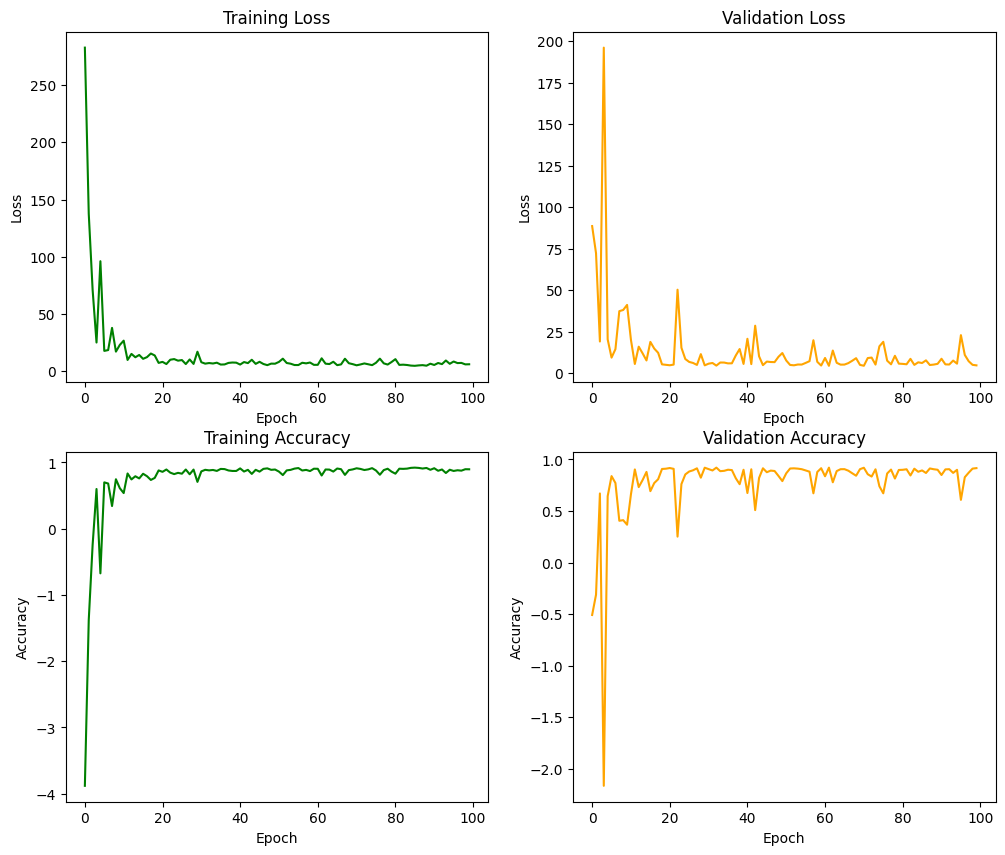

In [62]:
#  trực quan kết quả huấn luyện trên tập train và val cho bài toán nonlinear data classification
fig , ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax [0, 1].plot(val_losses, color='orange')
ax [0, 1].set(xlabel='Epoch', ylabel='Loss')
ax [0, 1].set_title('Validation Loss')

ax [1, 0].plot(train_r2, color='green')
ax [1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax [1, 0].set_title('Training Accuracy')

ax [1, 1].plot(val_r2, color='orange')
ax [1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax [1, 1].set_title('Validation Accuracy')

plt.show()

# B.Bài toán 2: Phân loại với dữ liệu phi tuyến
Đây là một bài toán đơn giản về classification trên dữ liệu phi tuyến (nonlinear data), bài tập này nhằm mục đích mô tả về khả năng của một mạng Multilayer Perceptron với những dữ liệu phân bố phức tạp hơn

## 1.Tải bộ dữ liệu
Bước đầu tiên là tải dữ liệu cho bài bằng lệnh "!gdown"

In [63]:
%cd /content/drive/MyDrive/Colab Notebooks/MODULE05/data

/content/drive/MyDrive/Colab Notebooks/MODULE05/data


In [ ]:
# https://drive.google.com/file/d/1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V/view?usp=drive_link
!gdown 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/drive/MyDrive/Colab Notebooks/MODULE05/data/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 21.5MB/s]


In [64]:
%cd ..

/content/drive/MyDrive/Colab Notebooks/MODULE05


## 2.Import các thư viện cần thiết

In [65]:
import numpy as np
import pandas as pd
import matplotlib . pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 3.Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán

In [66]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
  torch.cuda.manual_seed(random_state)

In [67]:
device, random_state

(device(type='cpu'), 59)

## 4.Đọc bộ dữ liệu
Dữ liệu cho bài toán phân loại được lưu dưới dạng .npy (Python NumPy Array File). Ta sử dụng np.load để tải dữ liệu từ file này, thu được một dictionary với hai phần: X là ma trận đặc trưng có kích thước (300, 2) (300 mẫu, mỗi
mẫu có 2 đặc trưng) và y là vector chứa 300 nhãn tương ứng

In [68]:
data_path = 'data/NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()

In [69]:
data.keys()

dict_keys(['X', 'labels'])

In [70]:
X, y = data['X'], data['labels']
print(X.shape, y.shape)

(300, 2) (300,)


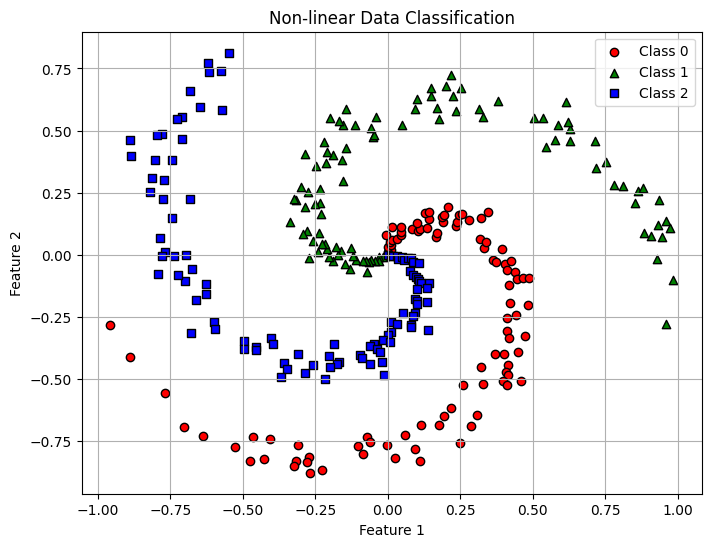

In [73]:
# Read Dataset and visualize
colors = ['red', 'green', 'blue']
markers = ['o', '^', 's']

plt.figure(figsize=(8, 6))

for i, class_label in enumerate(np.unique(y)):
    plt.scatter(
        X[y == class_label, 0],  # Lấy các điểm dữ liệu thuộc lớp class_label, cột 0 (Feature 1)
        X[y == class_label, 1],  # Lấy các điểm dữ liệu thuộc lớp class_label, cột 1 (Feature 2)
        c=colors[i],
        marker=markers[i],
        label=f'Class {class_label}',
        edgecolor='k'
    )

plt.title("Non-linear Data Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

## 5.Chia bộ dữ liệu train/val/test
Trong bài này, ta cũng chia dữ liệu thành ba bộ train/val/test theo tỉ lệ 7:2:1

In [74]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)

In [75]:
X_train.shape, X_val.shape, X_test.shape

((210, 2), (60, 2), (30, 2))

In [76]:
y_train.shape, y_val.shape, y_test.shape

((210,), (60,), (30,))

## 6.Chuẩn hóa đặc trưng đầu vào

In [77]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

## 7.Xây dựng DataLoader
Phần này được thực hiện tương tự như bài 1. Chúng ta xây dựng class CustomDataset để quản lý dữ liệu và sử dụng DataLoader cho các tập
train, val, và test, với batch_size là 32

In [78]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 8.Xây dựng mạng MLP
Để giải quyết bài toán phân loại phi tuyến với dữ liệu có 2 đặc trưng và 3 lớp, chúng ta xây dựng một mạng MLP gồm 2 lớp ẩn với hàm kích hoạt ReLU sau mỗi lớp. Cấu trúc này giúp mô hình học các đặc trưng phi tuyến trong dữ liệu.

In [79]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    out = self.output(x)
    return out.squeeze(1)

Tiếp theo, chúng ta thiết lập các tham số cho mạng MLP, bao gồm số lượng node cho đầu vào (input_dims), số node trong lớp ẩn (hidden_dims), và số node cho đầu ra (output_dims)

In [83]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128
lr = 1e-1


Để xác định output_dims - tức số lớp cần phân loại, tương ứng với số nhãn khác
nhau có trong y_train, chúng ta sử dụng cách đếm số nhãn duy nhất trong y_train
bằng hàm torch.unique, giúp mô hình tự động thích ứng với các bài toán có số lớp
khác nhau mà không cần phải thay đổi thủ công. Trong bài 1, hidden_dims được chọn là 64 vì bài 1 là bài toán hồi quy đơn giản, chỉ cần dự đoán một giá trị đầu ra liên tục (output_dims = 1), nên không đòi hỏi nhiều node trong lớp ẩn. Còn đối với bài 2, ta đặt hidden_dims là 128 vì đây là bài toán phân loại phi tuyến với 3 lớp, đòi hỏi mô hình có khả năng học các đặc trưng phức tạp để phân biệt giữa các lớp. Đặt số lượng node cao hơn sẽ giúp mạng đạt đủ độ phức tạp để học các đặc trưng mà vẫn đảm bảo hiệu quả tính toán.

## 9.Khai báo hàm loss và optimizer
Ta sử dụng hàm mất mát Cross Entropy cho bài toán phân loại đa lớp, cùng với thuật toán tối ưu SGD (Stochastic Gradient Descent). Về lý thuyết, Cross Entropy Loss được định nghĩa cho từng mẫu dữ liệu riêng lẻ (1 sample). Tuy nhiên, trong thực tế huấn luyện, dữ liệu thường được chia thành các batch nhỏ thông qua DataLoader, do đó ta thường tính loss cho một batch (nhiều samples cùng lúc) để tăng hiệu suất tính toán

In [84]:
model = MLP (input_dims = input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## 10.Xây dựng hàm tính độ chính xác
Để đánh giá hiệu suất của mô hình, chúng ta định nghĩa hàm compute_accuracy, tính độ chính xác phân loại (classification accuracy) bằng cách chia số dự đoán đúng cho tổng số mẫu.

công thức chung có dạng: Accuracy = Số lượng dự đoán đúng/
Tổng số mẫu

In [85]:
def compute_accuracy(y_hat, y_true):
  _, y_hat = torch.max(y_hat, dim =1)
  correct = (y_hat == y_true).sum().item ()
  accuracy = correct/len(y_true)
  return accuracy

## 11.Huấn luyện mô hình

In [86]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
  train_loss = 0.0
  train_target = []
  train_predict = []

  model.train()
  for X_samples, y_samples in train_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)
    optimizer.zero_grad()
    outputs = model(X_samples)
    loss = criterion(outputs, y_samples)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    train_predict.append(outputs.detach().cpu())
    train_target.append(y_samples.cpu())

  train_loss /= len(train_loader)
  train_losses.append(train_loss)

  train_predict = torch.cat(train_predict)
  train_target = torch.cat(train_target)
  train_acc = compute_accuracy(train_predict, train_target)
  train_accs.append(train_acc)

  val_loss = 0.0
  val_target = []
  val_predict = []

  model.eval()
  with torch.no_grad():
    for X_samples, y_samples in val_loader:
      X_samples = X_samples.to(device)
      y_samples = y_samples.to(device)
      outputs = model(X_samples)
      val_loss += criterion(outputs, y_samples).item()

      val_predict.append(outputs.cpu())
      val_target.append(y_samples.cpu())

  val_loss /= len(val_loader)
  val_losses.append(val_loss)

  val_predict = torch.cat(val_predict)
  val_target = torch.cat(val_target)
  val_acc = compute_accuracy(val_predict, val_target)
  val_accs.append(val_acc)

  print(f'\nEPOCH{epoch+1}:\tTraining loss:{train_loss:.3f}\tValidation loss:{val_loss:.3f}')




EPOCH1:	Training loss:0.928	Validation loss:0.872

EPOCH2:	Training loss:0.763	Validation loss:0.826

EPOCH3:	Training loss:0.710	Validation loss:0.809

EPOCH4:	Training loss:0.682	Validation loss:0.778

EPOCH5:	Training loss:0.671	Validation loss:0.755

EPOCH6:	Training loss:0.648	Validation loss:0.738

EPOCH7:	Training loss:0.634	Validation loss:0.721

EPOCH8:	Training loss:0.608	Validation loss:0.691

EPOCH9:	Training loss:0.604	Validation loss:0.678

EPOCH10:	Training loss:0.573	Validation loss:0.657

EPOCH11:	Training loss:0.578	Validation loss:0.638

EPOCH12:	Training loss:0.549	Validation loss:0.619

EPOCH13:	Training loss:0.543	Validation loss:0.601

EPOCH14:	Training loss:0.537	Validation loss:0.593

EPOCH15:	Training loss:0.522	Validation loss:0.569

EPOCH16:	Training loss:0.505	Validation loss:0.552

EPOCH17:	Training loss:0.493	Validation loss:0.547

EPOCH18:	Training loss:0.484	Validation loss:0.530

EPOCH19:	Training loss:0.471	Validation loss:0.513

EPOCH20:	Training lo

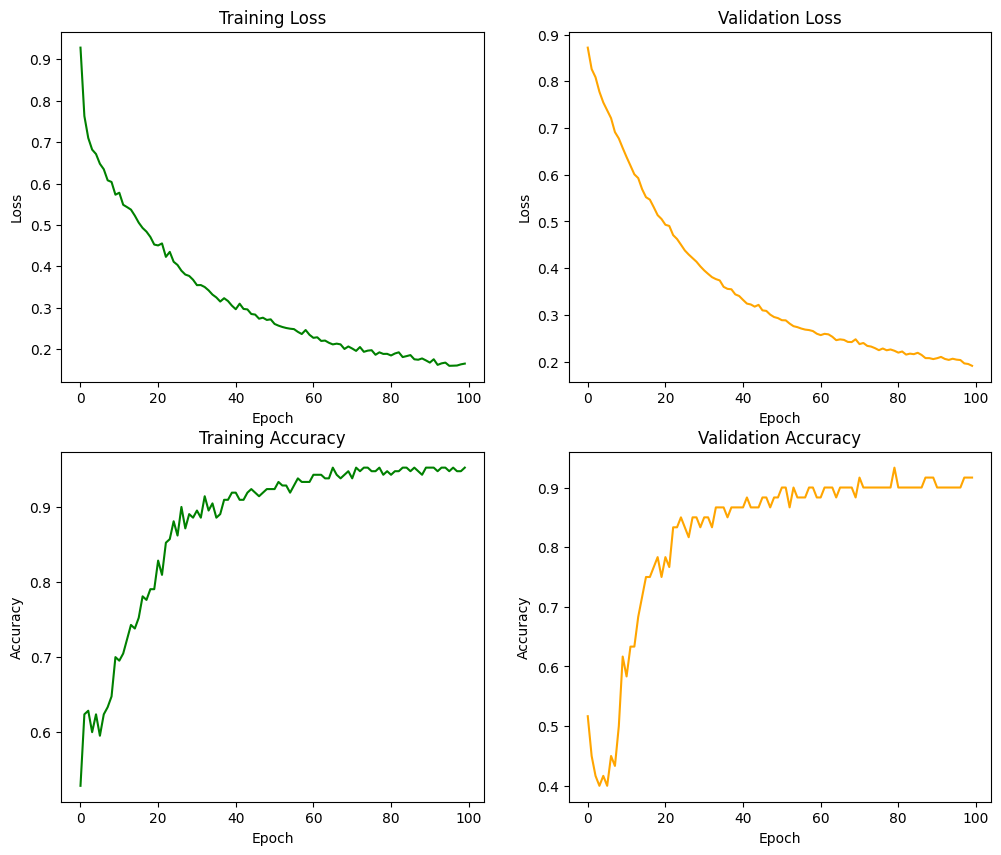

In [87]:
#  trực quan kết quả huấn luyện trên tập train và val cho bài toán nonlinear data classification
fig , ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax [0, 1].plot(val_losses, color='orange')
ax [0, 1].set(xlabel='Epoch', ylabel='Loss')
ax [0, 1].set_title('Validation Loss')

ax [1, 0].plot(train_accs, color='green')
ax [1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax [1, 0].set_title('Training Accuracy')

ax [1, 1].plot(val_accs, color='orange')
ax [1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax [1, 1].set_title('Validation Accuracy')

plt.show()

## 12.Đánh giá mô hình
Sau khi quá trình huấn luyện hoàn tất, chúng ta đánh giá mô hình trên tập test

In [88]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
  for X_samples, y_samples in test_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)
    outputs = model(X_samples)

    test_predict.append(outputs.cpu())
    test_target.append(y_samples.cpu())

  test_predict = torch.cat(test_predict)
  test_target = torch.cat(test_target)
  test_acc = compute_accuracy(test_predict, test_target)

  print('Evaluation on test set: ')
  print(f'Accuracy: {test_acc}')

Evaluation on test set: 
Accuracy: 0.9333333333333333


# C.Bài toán 3: Phân loại cảm xúc trên ảnh

## 1.Tải bộ dữ liệu
Tải dữ liệu cho bài bằng lệnh "!gdown"

In [1]:
%cd G:\AIO\EXERCISE\AIO-2024\MODULE05\WEEK03\data

G:\AIO\EXERCISE\AIO-2024\MODULE05\WEEK03\data


In [ ]:
!gdown 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=dd51c4d1-4b22-461f-a963-d5e4d23269ac
To: /content/drive/MyDrive/Colab Notebooks/MODULE05/data/FER-2013.zip
100% 63.3M/63.3M [00:00<00:00, 88.1MB/s]


In [2]:
%cd ..

G:\AIO\EXERCISE\AIO-2024\MODULE05\WEEK03


In [ ]:
!unzip FER-2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

## 2.Import các thư viện cần thiết

In [3]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 3.Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
  torch.cuda.manual_seed(random_state)

In [5]:
device, random_state

(device(type='cpu'), 59)

## 4.Đọc số lượng class trong dataset
Thiết lập đường dẫn đến thư mục train và test.
Chúng ta lấy danh sách tên các thư mục con trong thư mục train, đại diện cho các lớp cảm xúc khác nhau. Mỗi thư mục con này chứa các ảnh thuộc về một lớp cụ thể.


In [6]:
train_dir = 'data/FER-2013/train'
test_dir = 'data/FER-2013/test'

classes = os.listdir(train_dir)

In [7]:
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

### Sau đó, chúng ta xây dựng hai dict là label2idx và idx2label để ánh xạ giữa tên và chỉ số lớp, nhằm thuận tiện cho việc xử lý dữ liệu

In [8]:
label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls for cls, idx in label2idx.items()}

In [9]:
idx2label,label2idx

({0: 'angry',
  1: 'disgust',
  2: 'fear',
  3: 'happy',
  4: 'neutral',
  5: 'sad',
  6: 'surprise'},
 {'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6})

## 5.Xây dựng DataLoader
Xây dựng DataLoader cho bài toán phân loại cảm xúc ảnh
từ tập FER-2013.

### Trước tiên, lớp tùy chỉnh ImageDataset được tạo ra để quản lý và xử lý dữ liệu ảnh. Lớp này sẽ cung cấp các phương thức để lấy danh sách đường dẫn ảnh và nhãn, tính số lượng ảnh, cũng như chuẩn hóa từng ảnh đầu vào (nếu cần) trước khi đưa vào mô hình

In [11]:

class ImageDataset(Dataset):
  def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
    self.resize = Resize((img_height, img_width))
    self.norm = norm
    self.split = split
    self.train_ratio = train_ratio
    self.img_dir = img_dir
    self.label2idx = label2idx
    self.img_paths, self.img_labels = self.read_img_files()

    if split in ['train', 'val'] and 'train' in img_dir.lower():
      train_data, val_data = train_test_split(list(zip(self.img_paths, self.img_labels)),
                                              train_size=train_ratio,
                                              random_state=random_state,
                                              stratify=self.img_labels)
    if split == 'train':
      self.img_paths, self.img_labels = zip(*train_data)
    elif split == 'val':
      self.img_paths, self.img_labels = zip(*val_data)

  def read_img_files(self):
    img_paths = []
    img_labels = []
    for cls in self.label2idx.keys():
      for img in os.listdir(os.path.join(self.img_dir, cls)):
        img_paths.append(os.path.join(self.img_dir, cls, img))
        img_labels.append(cls)
    return img_paths , img_labels

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    cls = self.img_labels[idx]
    img = self.resize(read_image(img_path))
    img = img.type(torch.float32)
    label = self.label2idx[cls]

    if self.norm:
      img = (img/127.5) - 1

    return img, label

In [12]:
test_img_path = 'data/FER-2013/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print(f'Image height:{img_height}')
print(f'Image width:{img_width}')


Image height:128
Image width:128


In [13]:
img

array([[[ 50,  50,  50],
        [ 32,  32,  32],
        [ 15,  15,  15],
        ...,
        [133, 133, 133],
        [151, 151, 151],
        [ 86,  86,  86]],

       [[ 57,  57,  57],
        [ 34,  34,  34],
        [ 22,  22,  22],
        ...,
        [138, 138, 138],
        [151, 151, 151],
        [ 89,  89,  89]],

       [[ 61,  61,  61],
        [ 30,  30,  30],
        [ 24,  24,  24],
        ...,
        [142, 142, 142],
        [149, 149, 149],
        [ 89,  89,  89]],

       ...,

       [[103, 103, 103],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [149, 149, 149],
        [104, 104, 104],
        [ 85,  85,  85]],

       [[107, 107, 107],
        [111, 111, 111],
        [113, 113, 113],
        ...,
        [151, 151, 151],
        [120, 120, 120],
        [ 86,  86,  86]],

       [[104, 104, 104],
        [104, 104, 104],
        [112, 112, 112],
        ...,
        [143, 143, 143],
        [136, 136, 136],
        [ 83,  83,  83]]

### Sau đó, DataLoader được khởi tạo cho các tập train, val, và test với batch size là 256

In [14]:
batch_size = 256

train_dataset = ImageDataset(train_dir, True, label2idx, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Để trực quan hóa dữ liệu, chúng ta lấy một batch ảnh từ train_loader và hiển thị 9 hình đầu tiên. Các ảnh này được gắn nhãn cảm xúc tương ứng dựa trên idx2label, giúp ta có cái nhìn trực quan về dữ liệu mà mô hình sẽ được học.

c:\Python39\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


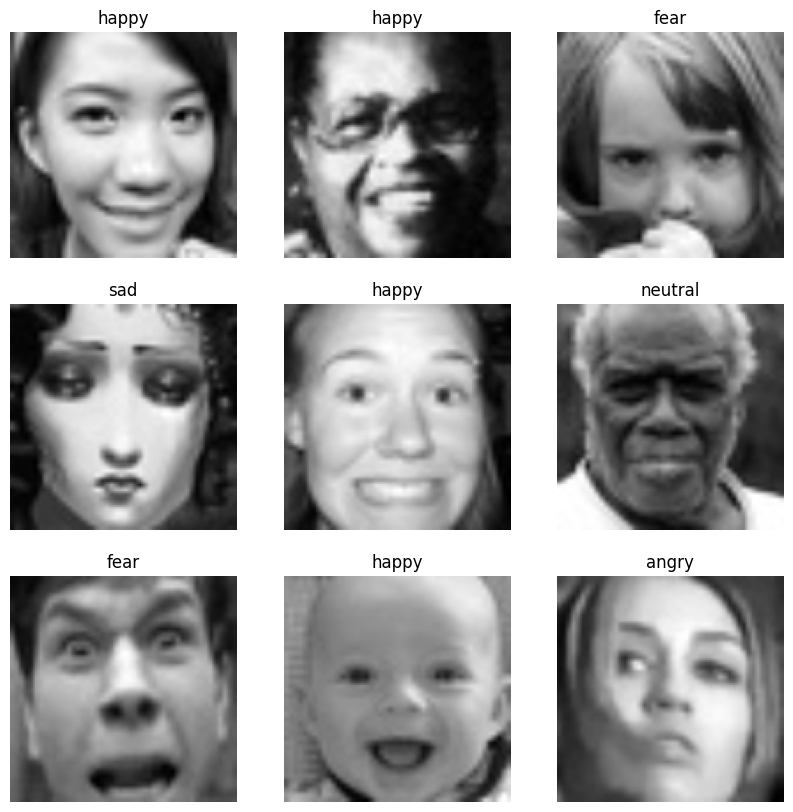

In [15]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize = (10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  minv = image_batch[i].numpy().min()
  maxv = image_batch[i].numpy().max()
  plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax =maxv, cmap="gray")
  label = label_batch[i]
  plt.title(idx2label[label.item()])
  plt.axis("off")

## 6.Xây dựng mạng MLP

In [16]:
class MLP (nn. Module ):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_dims, hidden_dims*4)
    self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
    self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)

  def forward(self, x):
    x = nn.Flatten()(x)
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    x = F.relu(x)
    x = self.linear3(x)
    x = F.relu(x)
    out = self.output(x)
    return out . squeeze (1)

In [17]:
input_dims = img_height*img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

## 7.Khai báo hàm loss và optimizer

In [18]:
model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [19]:
model

MLP(
  (linear1): Linear(in_features=16384, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=7, bias=True)
)

## 8.Xây dựng hàm tính độ chính xác

In [20]:
def compute_accuracy(y_hat, y_true):
  _, y_hat = torch.max(y_hat, dim=1)
  correct = (y_hat==y_true).sum().item()
  accuracy = correct/len(y_true)
  return accuracy

## 9.Huấn luyện mô hình

In [21]:
len(train_loader.dataset)

22967

In [22]:
len(val_loader.dataset)

5742

In [39]:
epochs = 50
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
  train_loss = 0.0
  train_target = []
  train_predict = []
  model.train()

  for X_samples, y_samples in train_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)
    optimizer.zero_grad()
    outputs = model(X_samples)
    loss = criterion(outputs, y_samples)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    train_predict.append(outputs.detach().cpu())
    train_target.append(y_samples.cpu())

  train_loss /= len(train_loader)
  train_losses.append(train_loss)

  train_predict = torch.cat(train_predict)
  train_target = torch.cat(train_target)
  train_acc = compute_accuracy(train_predict, train_target)
  train_accs.append(train_acc)

  val_loss = 0.0
  val_target = []
  val_predict = []
  model.eval()

  with torch.no_grad():
    for X_samples, y_samples in val_loader:
      X_samples = X_samples.to(device)
      y_samples = y_samples.to(device)
      outputs = model(X_samples)
      val_loss += criterion(outputs, y_samples).item()

      val_predict.append(outputs.cpu())
      val_target.append(y_samples.cpu())
  val_loss /= len(val_loader)
  val_losses.append(val_loss)

  val_predict = torch.cat(val_predict)
  val_target = torch.cat(val_target)
  val_acc = compute_accuracy(val_predict,val_target)
  val_accs.append(val_acc)

  print(f'\nEPOCH{epoch+1}:\tTraining loss:{train_loss:.3f}\tValidation loss:{val_loss:.3f}')


EPOCH1:	Training loss:1.719	Validation loss:1.710

EPOCH2:	Training loss:1.697	Validation loss:1.689

EPOCH3:	Training loss:1.676	Validation loss:1.672

EPOCH4:	Training loss:1.659	Validation loss:1.659

EPOCH5:	Training loss:1.645	Validation loss:1.650

EPOCH6:	Training loss:1.634	Validation loss:1.644

EPOCH7:	Training loss:1.623	Validation loss:1.633

EPOCH8:	Training loss:1.613	Validation loss:1.629

EPOCH9:	Training loss:1.605	Validation loss:1.621

EPOCH10:	Training loss:1.595	Validation loss:1.615

EPOCH11:	Training loss:1.588	Validation loss:1.612

EPOCH12:	Training loss:1.579	Validation loss:1.605

EPOCH13:	Training loss:1.570	Validation loss:1.601

EPOCH14:	Training loss:1.563	Validation loss:1.596

EPOCH15:	Training loss:1.554	Validation loss:1.591

EPOCH16:	Training loss:1.546	Validation loss:1.586

EPOCH17:	Training loss:1.538	Validation loss:1.584

EPOCH18:	Training loss:1.530	Validation loss:1.581

EPOCH19:	Training loss:1.522	Validation loss:1.574

EPOCH20:	Training lo

In [23]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
  train_loss = 0.0
  train_target = []
  train_predict = []
  model.train()

  for X_samples, y_samples in train_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)
    optimizer.zero_grad()
    outputs = model(X_samples)
    loss = criterion(outputs, y_samples)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    train_predict.append(outputs.detach().cpu())
    train_target.append(y_samples.cpu())

  train_loss /= len(train_loader)
  train_losses.append(train_loss)

  train_predict = torch.cat(train_predict)
  train_target = torch.cat(train_target)
  train_acc = compute_accuracy(train_predict, train_target)
  train_accs.append(train_acc)

  val_loss = 0.0
  val_target = []
  val_predict = []
  model.eval()

  with torch.no_grad():
    for X_samples, y_samples in val_loader:
      X_samples = X_samples.to(device)
      y_samples = y_samples.to(device)
      outputs = model(X_samples)
      val_loss += criterion(outputs, y_samples).item()

      val_predict.append(outputs.cpu())
      val_target.append(y_samples.cpu())
  val_loss /= len(val_loader)
  val_losses.append(val_loss)

  val_predict = torch.cat(val_predict)
  val_target = torch.cat(val_target)
  val_acc = compute_accuracy(val_predict,val_target)
  val_accs.append(val_acc)

  print(f'\nEPOCH{epoch+1}:\tTraining loss:{train_loss:.3f}\tValidation loss:{val_loss:.3f}')


EPOCH1:	Training loss:1.920	Validation loss:1.896

EPOCH2:	Training loss:1.869	Validation loss:1.846

EPOCH3:	Training loss:1.823	Validation loss:1.809

EPOCH4:	Training loss:1.792	Validation loss:1.783

EPOCH5:	Training loss:1.769	Validation loss:1.762

EPOCH6:	Training loss:1.747	Validation loss:1.741

EPOCH7:	Training loss:1.726	Validation loss:1.719

EPOCH8:	Training loss:1.704	Validation loss:1.698

EPOCH9:	Training loss:1.682	Validation loss:1.680

EPOCH10:	Training loss:1.665	Validation loss:1.665

EPOCH11:	Training loss:1.651	Validation loss:1.654

EPOCH12:	Training loss:1.637	Validation loss:1.645

EPOCH13:	Training loss:1.626	Validation loss:1.637

EPOCH14:	Training loss:1.616	Validation loss:1.631

EPOCH15:	Training loss:1.607	Validation loss:1.630

EPOCH16:	Training loss:1.598	Validation loss:1.618

EPOCH17:	Training loss:1.590	Validation loss:1.615

EPOCH18:	Training loss:1.581	Validation loss:1.608

EPOCH19:	Training loss:1.573	Validation loss:1.603

EPOCH20:	Training lo

### Kết quả huấn luyện được trực quan hóa lên đồ thị như sau

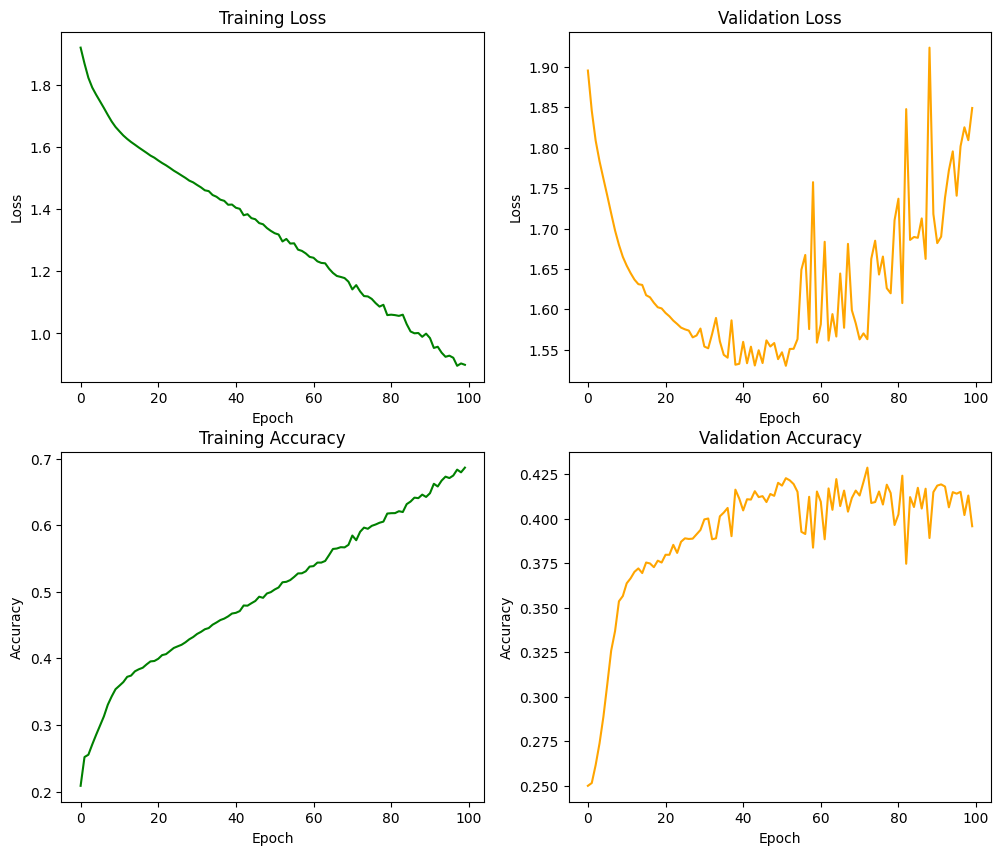

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')
ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')
ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch',ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')
plt.show()

## 10.Đánh giá mô hình

In [25]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
  for X_samples, y_samples in test_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)
    outputs = model(X_samples)

    test_predict.append(outputs.cpu())
    test_target.append(y_samples.cpu())

  test_predict = torch.cat(test_predict)
  test_target = torch.cat(test_target)
  val_acc = compute_accuracy(test_predict, test_target)

print('Evaluation on test set:')
print(f'Accuracy:{ val_acc }')